In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import talib

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from math import sqrt
from matplotlib import pyplot
from numpy import array
import numpy as np
from keras.layers import LSTM , CuDNNLSTM
import matplotlib.pyplot as plt
import pandas as pd
from talib.abstract import *  
sns.set()



C:\Users\user\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  del sys.path[0]
Using TensorFlow backend.
C:\Users\user\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\

In [2]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

         Date       Open       High        Low      Close  Adj Close  \
0  2007-01-02  55.521000  57.466499  55.371399  56.867901  38.202568   
1  2007-01-03  57.167198  58.813400  57.017502  57.840599  38.856010   
2  2007-01-04  57.765800  57.990299  57.092400  57.765800  38.805763   
3  2007-01-05  57.616100  57.691002  56.792999  56.792999  38.152256   
4  2007-01-08  56.119598  56.119598  55.146900  55.296501  37.146938   

       Volume  
0  27682832.0  
1  38041509.0  
2  27239137.0  
3  24146636.0  
4  30340993.0  


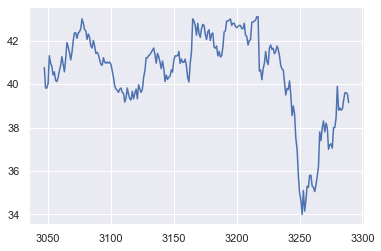

In [3]:
df = pd.read_csv('input/2882.TW.csv')
print(df.head())
series = df.dropna(axis=0,how='any')
series = series['Close']
plt.plot(series[-243:])

In [50]:
from talib import abstract
df = pd.read_csv('input/2882.TW.csv')
print(df[df.isnull().any(axis=1)])
df = df.dropna()
df = df.rename(columns={"Date": "date", "Open": "open", "High": "high", "Low": "low", "Close": "close", "Adj Close": "adj Close",
                        "Volume": "volume"})
#df = df.drop(['date', 'adj Close'], axis=1)

            Date  Open  High  Low  Close  Adj Close  Volume
2247  2016-01-30   NaN   NaN  NaN    NaN        NaN     NaN
2327  2016-06-04   NaN   NaN  NaN    NaN        NaN     NaN
2396  2016-09-10   NaN   NaN  NaN    NaN        NaN     NaN
2502  2017-02-18   NaN   NaN  NaN    NaN        NaN     NaN
2571  2017-06-03   NaN   NaN  NaN    NaN        NaN     NaN


In [51]:
ta_list = talib.get_functions()

# 迴圈執行，看看結果吧！
for x in ta_list:
    try:
        # x 為技術指標的代碼，透過迴圈填入，再透過 eval 計算出 output
        output = eval('abstract.'+x+'(df)')
        # 如果輸出是一維資料，幫這個指標取名為 x 本身；多維資料則不需命名
        output.name = x.lower() if type(output) == pd.core.series.Series else None
        # 透過 merge 把輸出結果併入 df DataFrame
        df = pd.merge(df, pd.DataFrame(output), left_on = df.index, right_on = output.index)
        df = df.set_index('key_0')
    except:
        print(x)

MAVP


In [53]:
df = df.drop(['date', 'adj Close'], axis=1)
df.head()

,open,high,low,close,volume,ht_dcperiod,ht_dcphase,inphase,quadrature,sine,...,linearreg_slope,stddev,tsf,var,atr,natr,trange,ad,adosc,obv
key_0,,,,,,,,,,,,,,,,,,,,,
0,55.521000,57.466499,55.371399,56.867901,27682832.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.186412e+07,NaN,27682832.0
1,57.167198,58.813400,57.017502,57.840599,38041509.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.945499,8.693027e+06,NaN,65724341.0
2,57.765800,57.990299,57.092400,57.765800,27239137.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.897899,2.231112e+07,NaN,38485204.0
3,57.616100,57.691002,56.792999,56.792999,24146636.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.972801,-1.835512e+06,NaN,14338568.0
4,56.119598,56.119598,55.146900,55.296501,30340993.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0.918391,NaN,0.843442,NaN,NaN,1.646099,-2.284361e+07,NaN,-16002425.0


In [76]:
null_column_list_number = df.isnull().sum().values
null_column_name_list = df.isnull().sum().index
null_column_list_number

array([   0,    0,    0,    0,    0,   32,   63,   32,   32,   63,   63,
          0,    0,    0,   29,    0,   29,    0,   29,   29,    0,    0,
          0,    0,   29, 3285, 3285,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   27,   40,   25,   14,
         14,   14,    0,   13,   14,   14,   33,   33,   33,   33,   33,
         33,   33,   33,   33,   14,   14,   13,   10,   14,   13,   25,
         10,   10,   10,   10,   14,    8,    8,    6,    6,   20,   20,
         88,   28,   13,    4,    4,    4,   58,   29,   63,   30,   29,
         32,   32,   13,   13,    1,    1,   29,   24,   87,   29,   29,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [78]:
for i in range(len(null_column_list_number)):
    if null_column_list_number[i] > 0:
        index = i
        print(null_column_name_list[i], " ", null_column_list_number[i])

ht_dcperiod   32
ht_dcphase   63
inphase   32
quadrature   32
sine   63
leadsine   63
max_x   29
min_x   29
min_y   29
max_y   29
sum   29
acos   3285
asin   3285
adx   27
adxr   40
apo   25
aroondown   14
aroonup   14
aroonosc   14
cci   13
cmo   14
dx   14
macd_x   33
macdsignal_x   33
macdhist_x   33
macd_y   33
macdsignal_y   33
macdhist_y   33
macd   33
macdsignal   33
macdhist   33
mfi   14
minus_di   14
minus_dm   13
mom   10
plus_di   14
plus_dm   13
ppo   25
roc   10
rocp   10
rocr   10
rocr100   10
rsi   14
slowk   8
slowd   8
fastk_x   6
fastd_x   6
fastk_y   20
fastd_y   20
trix   88
ultosc   28
willr   13
upperband   4
middleband   4
lowerband   4
dema   58
ema   29
ht_trendline   63
kama   30
ma   29
mama   32
fama   32
midpoint   13
midprice   13
sar   1
sarext   1
sma   29
t3   24
tema   87
trima   29
wma   29
beta   5
correl   29
linearreg   13
linearreg_angle   13
linearreg_intercept   13
linearreg_slope   13
stddev   4
tsf   13
var   4
atr   14
natr   14
trange   1
a

In [79]:
df

,open,high,low,close,volume,ht_dcperiod,ht_dcphase,inphase,quadrature,sine,...,linearreg_slope,stddev,tsf,var,atr,natr,trange,ad,adosc,obv
key_0,,,,,,,,,,,,,,,,,,,,,
0,55.521000,57.466499,55.371399,56.867901,27682832.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.186412e+07,NaN,2.768283e+07
1,57.167198,58.813400,57.017502,57.840599,38041509.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.945499,8.693027e+06,NaN,6.572434e+07
2,57.765800,57.990299,57.092400,57.765800,27239137.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.897899,2.231112e+07,NaN,3.848520e+07
3,57.616100,57.691002,56.792999,56.792999,24146636.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.972801,-1.835512e+06,NaN,1.433857e+07
4,56.119598,56.119598,55.146900,55.296501,30340993.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0.918391,NaN,0.843442,NaN,NaN,1.646099,-2.284361e+07,NaN,-1.600242e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3285,39.250000,39.500000,39.049999,39.250000,11447894.0,19.710384,154.649448,1.814150,0.241700,0.428155,...,0.170220,0.169116,39.523077,0.028600,0.759094,1.933998,0.650002,1.408137e+10,5.124562e+06,9.669979e+10
3286,39.500000,39.900002,39.500000,39.599998,14051677.0,19.028121,154.264077,1.361271,-1.829408,0.434224,...,0.200769,0.304302,39.866483,0.092600,0.751302,1.897227,0.650002,1.407434e+10,1.143105e+06,9.671385e+10
3287,39.400002,39.700001,39.299999,39.599998,12594120.0,18.344453,168.946908,0.366481,-1.494815,0.191719,...,0.191319,0.347275,39.981317,0.120600,0.726209,1.833861,0.400002,1.408064e+10,1.413969e+06,9.671385e+10


In [81]:
df = df.drop(['acos', 'asin'], axis=1)

In [84]:
df = df.dropna()

In [129]:
print(len(df.columns))

177


In [130]:
# configure
n_lag = 30
n_seq = 7
pred_steps = n_seq
n_test = 192
n_epochs =1500
n_batch = 32
n_neurons = 32
features = 177

In [132]:
cols = ['close']  + [col for col in df if col != 'close']
df = df[cols]
df

,close,open,high,low,volume,ht_dcperiod,ht_dcphase,inphase,quadrature,sine,...,linearreg_slope,stddev,tsf,var,atr,natr,trange,ad,adosc,obv
key_0,,,,,,,,,,,,,,,,,,,,,
88,53.126598,52.827301,53.500702,52.303501,18869070.0,14.738178,249.719363,-0.571632,0.131244,-0.938006,...,0.034044,0.226959,53.376572,0.051510,1.049726,1.975896,1.197201,-1.924823e+08,-1.154568e+07,9.867138e+07
89,53.051800,53.051800,53.500702,52.752399,12259082.0,14.773288,268.263490,-0.416688,0.209047,-0.999541,...,-0.066437,0.214795,52.831414,0.046137,1.028196,1.938099,0.748303,-1.949315e+08,-1.019757e+07,8.641230e+07
90,54.099300,53.500702,54.174099,53.425900,26329028.0,14.770787,290.092182,-0.353590,0.454140,-0.939141,...,-0.088146,0.488140,52.818248,0.238280,1.034918,1.912997,1.122299,-1.738668e+08,-2.016620e+06,1.127413e+08
91,53.949699,54.099300,54.323799,53.799999,12844439.0,14.747083,27.149310,-0.041047,0.260862,0.456311,...,-0.037001,0.568673,53.153735,0.323389,0.998409,1.850630,0.523800,-1.793695e+08,-2.373835e+05,9.989688e+07
92,52.902100,53.575500,53.575500,52.528000,17892139.0,14.728134,64.599030,-0.206071,0.111983,0.903328,...,-0.012827,0.496333,53.212109,0.246346,1.028644,1.944430,1.421699,-1.844818e+08,-1.114569e+06,8.200474e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3285,39.250000,39.250000,39.500000,39.049999,11447894.0,19.710384,154.649448,1.814150,0.241700,0.428155,...,0.170220,0.169116,39.523077,0.028600,0.759094,1.933998,0.650002,1.408137e+10,5.124562e+06,9.669979e+10
3286,39.599998,39.500000,39.900002,39.500000,14051677.0,19.028121,154.264077,1.361271,-1.829408,0.434224,...,0.200769,0.304302,39.866483,0.092600,0.751302,1.897227,0.650002,1.407434e+10,1.143105e+06,9.671385e+10
3287,39.599998,39.400002,39.700001,39.299999,12594120.0,18.344453,168.946908,0.366481,-1.494815,0.191719,...,0.191319,0.347275,39.981317,0.120600,0.726209,1.833861,0.400002,1.408064e+10,1.413969e+06,9.671385e+10


In [133]:
seq2seq_raw_values = df.values
seq2seq_raw_values = seq2seq_raw_values[:].reshape(len(seq2seq_raw_values),177)
test_value = seq2seq_raw_values[:,0].reshape(len(seq2seq_raw_values),1)
# rescale values to -1, 1
scaler_trans = MinMaxScaler(feature_range=(-1, 1))
transfor_fun = scaler_trans.fit_transform(test_value)
# rescale values to -1, 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_values = scaler.fit_transform(seq2seq_raw_values)
########################
#scaled_values = seq2seq_raw_values
#print(scaled_values[:27])
# transform into supervised learning problem X, y
supervised = series_to_supervised(scaled_values, n_lag, n_seq)
supervised_values = supervised.values
supervised_values.shape
train, test = supervised_values[:-243*1], supervised_values[-243*1:]

print('train',train.shape)
print('test',test.shape)

train (2918, 6549)
test (243, 6549)


In [134]:
encoder_input_data , decoder_target_data = train[: ,:(n_lag+n_seq-1)*features] , train[:,n_lag*features:]
decoder_target_data = decoder_target_data[: , ::features]
encoder_input_data = encoder_input_data.reshape((encoder_input_data.shape[0],(n_lag+n_seq-1),features))
decoder_target_data = decoder_target_data.reshape((decoder_target_data.shape[0],decoder_target_data.shape[1],1))
print("encoder_input_data",encoder_input_data.shape,"decoder_target_data",decoder_target_data.shape)

encoder_input_data (2918, 36, 177) decoder_target_data (2918, 7, 1)


In [135]:
print('encoder_input_data[-1]', encoder_input_data[0][-1][0])
print('decoder_target_data[-1]', decoder_target_data[0])

encoder_input_data[-1] 0.6994780235757665
decoder_target_data[-1] [[0.57693506]
 [0.57693506]
 [0.56818505]
 [0.71406913]
 [0.71406913]
 [0.69947802]
 [0.78409268]]


In [93]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate
from keras.optimizers import Adam

# convolutional layer parameters
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(6)] 

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, features))
x = history_seq

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
               padding='causal',
               dilation_rate=dilation_rate)(x)
    x = Dropout(0.4)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)

# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':n_seq})(x)

model = Model(history_seq, pred_seq_train)
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 177)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          11360     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
______

In [94]:
batch_size = 32
model.compile(Adam(), loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=700,
                    validation_split=0.15)



Train on 2480 samples, validate on 438 samples
Epoch 1/700
2480/2480 [==============================] - 6s 2ms/step - loss: 0.5820 - val_loss: 0.2601
Epoch 2/700
2480/2480 [==============================] - 1s 369us/step - loss: 0.2731 - val_loss: 0.1818
Epoch 3/700
2480/2480 [==============================] - 1s 367us/step - loss: 0.2031 - val_loss: 0.1601
Epoch 4/700
2480/2480 [==============================] - 1s 370us/step - loss: 0.1709 - val_loss: 0.1412
Epoch 5/700
2480/2480 [==============================] - 1s 366us/step - loss: 0.1542 - val_loss: 0.0957
Epoch 6/700
2480/2480 [==============================] - 1s 370us/step - loss: 0.1413 - val_loss: 0.0682
Epoch 7/700
2480/2480 [==============================] - 1s 372us/step - loss: 0.1319 - val_loss: 0.0676
Epoch 8/700
2480/2480 [==============================] - 1s 370us/step - loss: 0.1230 - val_loss: 0.0854
Epoch 9/700
2480/2480 [==============================] - 1s 367us/step - loss: 0.1159 - val_loss: 0.1179
Epoch 10

2480/2480 [==============================] - 1s 368us/step - loss: 0.0707 - val_loss: 0.0517
Epoch 75/700
2480/2480 [==============================] - 1s 362us/step - loss: 0.0705 - val_loss: 0.0465
Epoch 76/700
2480/2480 [==============================] - 1s 365us/step - loss: 0.0701 - val_loss: 0.0525
Epoch 77/700
2480/2480 [==============================] - 1s 364us/step - loss: 0.0709 - val_loss: 0.0394
Epoch 78/700
2480/2480 [==============================] - 1s 363us/step - loss: 0.0687 - val_loss: 0.0435
Epoch 79/700
2480/2480 [==============================] - 1s 364us/step - loss: 0.0691 - val_loss: 0.0400
Epoch 80/700
2480/2480 [==============================] - 1s 368us/step - loss: 0.0685 - val_loss: 0.0706
Epoch 81/700
2480/2480 [==============================] - 1s 365us/step - loss: 0.0693 - val_loss: 0.0393
Epoch 82/700
2480/2480 [==============================] - 1s 365us/step - loss: 0.0703 - val_loss: 0.0463
Epoch 83/700
2480/2480 [==============================] - 1

2480/2480 [==============================] - 1s 363us/step - loss: 0.0651 - val_loss: 0.0438
Epoch 151/700
2480/2480 [==============================] - 1s 364us/step - loss: 0.0671 - val_loss: 0.0409
Epoch 152/700
2480/2480 [==============================] - 1s 364us/step - loss: 0.0660 - val_loss: 0.0519
Epoch 153/700
2480/2480 [==============================] - 1s 362us/step - loss: 0.0661 - val_loss: 0.0484
Epoch 154/700
2480/2480 [==============================] - 1s 366us/step - loss: 0.0671 - val_loss: 0.0399
Epoch 155/700
2480/2480 [==============================] - 1s 366us/step - loss: 0.0660 - val_loss: 0.0372
Epoch 156/700
2480/2480 [==============================] - 1s 365us/step - loss: 0.0666 - val_loss: 0.0562
Epoch 157/700
2480/2480 [==============================] - 1s 356us/step - loss: 0.0660 - val_loss: 0.0489
Epoch 158/700
2480/2480 [==============================] - 1s 367us/step - loss: 0.0661 - val_loss: 0.0435
Epoch 159/700
2480/2480 [==========================

2480/2480 [==============================] - 1s 365us/step - loss: 0.0663 - val_loss: 0.0390
Epoch 227/700
2480/2480 [==============================] - 1s 366us/step - loss: 0.0652 - val_loss: 0.0400
Epoch 228/700
2480/2480 [==============================] - 1s 361us/step - loss: 0.0637 - val_loss: 0.0389
Epoch 229/700
2480/2480 [==============================] - 1s 363us/step - loss: 0.0655 - val_loss: 0.0515
Epoch 230/700
2480/2480 [==============================] - 1s 366us/step - loss: 0.0647 - val_loss: 0.0416
Epoch 231/700
2480/2480 [==============================] - 1s 365us/step - loss: 0.0647 - val_loss: 0.0568
Epoch 232/700
2480/2480 [==============================] - 1s 364us/step - loss: 0.0650 - val_loss: 0.0464
Epoch 233/700
2480/2480 [==============================] - 1s 365us/step - loss: 0.0639 - val_loss: 0.0822
Epoch 234/700
2480/2480 [==============================] - 1s 365us/step - loss: 0.0656 - val_loss: 0.0374
Epoch 235/700
2480/2480 [==========================

2480/2480 [==============================] - 1s 367us/step - loss: 0.0643 - val_loss: 0.0474
Epoch 303/700
2480/2480 [==============================] - 1s 364us/step - loss: 0.0632 - val_loss: 0.0472
Epoch 304/700
2480/2480 [==============================] - 1s 365us/step - loss: 0.0670 - val_loss: 0.0641
Epoch 305/700
2480/2480 [==============================] - 1s 365us/step - loss: 0.0634 - val_loss: 0.0629
Epoch 306/700
2480/2480 [==============================] - 1s 365us/step - loss: 0.0636 - val_loss: 0.0792
Epoch 307/700
2480/2480 [==============================] - 1s 366us/step - loss: 0.0631 - val_loss: 0.0396
Epoch 308/700
2480/2480 [==============================] - 1s 365us/step - loss: 0.0634 - val_loss: 0.0412
Epoch 309/700
2480/2480 [==============================] - 1s 365us/step - loss: 0.0635 - val_loss: 0.0391
Epoch 310/700
2480/2480 [==============================] - 1s 364us/step - loss: 0.0643 - val_loss: 0.0641
Epoch 311/700
2480/2480 [==========================

2480/2480 [==============================] - 1s 363us/step - loss: 0.0630 - val_loss: 0.0342
Epoch 379/700
2480/2480 [==============================] - 1s 366us/step - loss: 0.0637 - val_loss: 0.0489
Epoch 380/700
2480/2480 [==============================] - 1s 366us/step - loss: 0.0633 - val_loss: 0.0342
Epoch 381/700
2480/2480 [==============================] - 1s 362us/step - loss: 0.0624 - val_loss: 0.0420
Epoch 382/700
2480/2480 [==============================] - 1s 366us/step - loss: 0.0633 - val_loss: 0.0428
Epoch 383/700
2480/2480 [==============================] - 1s 371us/step - loss: 0.0625 - val_loss: 0.0562
Epoch 384/700
2480/2480 [==============================] - 1s 369us/step - loss: 0.0642 - val_loss: 0.0523
Epoch 385/700
2480/2480 [==============================] - 1s 364us/step - loss: 0.0635 - val_loss: 0.0338
Epoch 386/700
2480/2480 [==============================] - 1s 364us/step - loss: 0.0631 - val_loss: 0.0417
Epoch 387/700
2480/2480 [==========================

2480/2480 [==============================] - 1s 367us/step - loss: 0.0638 - val_loss: 0.0394
Epoch 455/700
2480/2480 [==============================] - 1s 366us/step - loss: 0.0609 - val_loss: 0.0383
Epoch 456/700
2480/2480 [==============================] - 1s 364us/step - loss: 0.0618 - val_loss: 0.0294
Epoch 457/700
2480/2480 [==============================] - 1s 365us/step - loss: 0.0630 - val_loss: 0.0383
Epoch 458/700
2480/2480 [==============================] - 1s 365us/step - loss: 0.0632 - val_loss: 0.0440
Epoch 459/700
2480/2480 [==============================] - 1s 362us/step - loss: 0.0636 - val_loss: 0.0393
Epoch 460/700
2480/2480 [==============================] - 1s 365us/step - loss: 0.0628 - val_loss: 0.0588
Epoch 461/700
2480/2480 [==============================] - 1s 364us/step - loss: 0.0640 - val_loss: 0.0321
Epoch 462/700
2480/2480 [==============================] - 1s 365us/step - loss: 0.0628 - val_loss: 0.0299
Epoch 463/700
2480/2480 [==========================

2480/2480 [==============================] - 1s 363us/step - loss: 0.0643 - val_loss: 0.0262
Epoch 531/700
2480/2480 [==============================] - 1s 372us/step - loss: 0.0630 - val_loss: 0.0334
Epoch 532/700
2480/2480 [==============================] - 1s 369us/step - loss: 0.0627 - val_loss: 0.0496
Epoch 533/700
2480/2480 [==============================] - 1s 367us/step - loss: 0.0621 - val_loss: 0.0396
Epoch 534/700
2480/2480 [==============================] - 1s 366us/step - loss: 0.0627 - val_loss: 0.0243
Epoch 535/700
2480/2480 [==============================] - 1s 362us/step - loss: 0.0632 - val_loss: 0.0636
Epoch 536/700
2480/2480 [==============================] - 1s 365us/step - loss: 0.0638 - val_loss: 0.0540
Epoch 537/700
2480/2480 [==============================] - 1s 363us/step - loss: 0.0631 - val_loss: 0.0272
Epoch 538/700
2480/2480 [==============================] - 1s 364us/step - loss: 0.0631 - val_loss: 0.0270
Epoch 539/700
2480/2480 [==========================

2480/2480 [==============================] - 1s 359us/step - loss: 0.0611 - val_loss: 0.0293
Epoch 607/700
2480/2480 [==============================] - 1s 361us/step - loss: 0.0625 - val_loss: 0.0318
Epoch 608/700
2480/2480 [==============================] - 1s 360us/step - loss: 0.0630 - val_loss: 0.0266
Epoch 609/700
2480/2480 [==============================] - 1s 362us/step - loss: 0.0639 - val_loss: 0.0319
Epoch 610/700
2480/2480 [==============================] - 1s 362us/step - loss: 0.0643 - val_loss: 0.0334
Epoch 611/700
2480/2480 [==============================] - 1s 360us/step - loss: 0.0624 - val_loss: 0.0527
Epoch 612/700
2480/2480 [==============================] - 1s 361us/step - loss: 0.0622 - val_loss: 0.0394
Epoch 613/700
2480/2480 [==============================] - 1s 359us/step - loss: 0.0621 - val_loss: 0.0264
Epoch 614/700
2480/2480 [==============================] - 1s 362us/step - loss: 0.0622 - val_loss: 0.0279
Epoch 615/700
2480/2480 [==========================

2480/2480 [==============================] - 1s 363us/step - loss: 0.0622 - val_loss: 0.0730
Epoch 683/700
2480/2480 [==============================] - 1s 361us/step - loss: 0.0621 - val_loss: 0.0403
Epoch 684/700
2480/2480 [==============================] - 1s 362us/step - loss: 0.0622 - val_loss: 0.0513
Epoch 685/700
2480/2480 [==============================] - 1s 369us/step - loss: 0.0645 - val_loss: 0.0660
Epoch 686/700
2480/2480 [==============================] - 1s 369us/step - loss: 0.0639 - val_loss: 0.0322
Epoch 687/700
2480/2480 [==============================] - 1s 375us/step - loss: 0.0622 - val_loss: 0.0422
Epoch 688/700
2480/2480 [==============================] - 1s 360us/step - loss: 0.0622 - val_loss: 0.0533
Epoch 689/700
2480/2480 [==============================] - 1s 364us/step - loss: 0.0631 - val_loss: 0.0492
Epoch 690/700
2480/2480 [==============================] - 1s 364us/step - loss: 0.0626 - val_loss: 0.0367
Epoch 691/700
2480/2480 [==========================

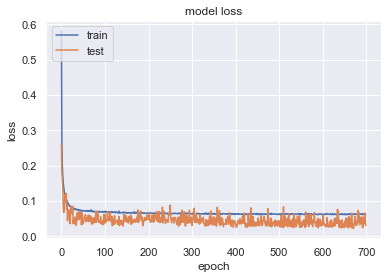

In [95]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [112]:
def predict_sequence(input_tensor):

    history_tensor = input_tensor[:,:(-pred_steps+1),:]
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_tensor)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction along with corresponding exogenous features
        # to the history tensor
        last_step_exog = input_tensor[:,[(-pred_steps+1)+i],1:]
        last_step_tensor = np.concatenate([last_step_pred.reshape((1,1,1)), 
                                           last_step_exog], axis=-1)
        history_tensor = np.concatenate([history_tensor, last_step_tensor], axis=1)

    return pred_sequence

In [113]:
seq2seq_raw_values = df.values
seq2seq_raw_values = seq2seq_raw_values[:].reshape(len(seq2seq_raw_values),features)
test_value = seq2seq_raw_values[:,0].reshape(len(seq2seq_raw_values),1)
# rescale values to -1, 1
scaler_trans = MinMaxScaler(feature_range=(-1, 1))
transfor_fun = scaler_trans.fit_transform(test_value)
# rescale values to -1, 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_values = scaler.fit_transform(seq2seq_raw_values)
########################
#scaled_values = seq2seq_raw_values
#print(scaled_values[:27])
# transform into supervised learning problem X, y
supervised = series_to_supervised(scaled_values, n_lag, n_seq)
supervised_values = supervised.values
supervised_values.shape
test =  supervised_values[-245*1:]

print('test',test.shape)

test (245, 6549)


In [114]:
test_input_seq , test_output_seq = test[: , :n_lag*features] , test[:,n_lag*features:]
test_output_seq = test_output_seq[: , ::features]
test_input_seq = test_input_seq.reshape((test_input_seq.shape[0],n_lag,features))
print('test_input_seq',test_input_seq.shape)
print('test_output_seq',test_output_seq.shape)


test_input_seq (245, 30, 177)
test_output_seq (245, 7)


In [115]:
test_input_seq[-1][-1]

array([-2.13392936e-01, -2.27063210e-01, -1.95971723e-01, -2.19966576e-01,
       -9.99423736e-01, -3.57237957e-01,  4.76561545e-01,  5.52710305e-02,
        3.03663619e-01, -6.53309159e-01, -9.97304305e-01,  1.00000000e+00,
       -2.11181836e-01, -8.15970870e-01, -3.26226282e-01,  1.00000000e+00,
       -2.42802442e-01,  9.94971716e-01, -2.42802442e-01, -3.26226282e-01,
        9.94971716e-01,  1.00000000e+00, -4.81084090e-01, -8.27555687e-01,
       -2.76533385e-01,  4.06907985e-01, -2.30769231e-01,  3.61535238e-01,
       -1.00000000e+00, -1.00000000e+00, -2.30769231e-01,  1.00517726e-01,
        1.00517726e-01,  9.32361419e-01, -1.00000000e+00, -6.21911604e-02,
        3.20074701e-01,  0.00000000e+00, -4.64608719e-01, -3.42964784e-01,
        2.47438676e-01, -1.42857143e-01,  7.14285714e-01,  4.28571429e-01,
       -2.49993750e-01,  2.24603676e-01,  1.92596769e-01, -4.31247780e-01,
        1.88199099e-01,  1.42436758e-01,  1.07711440e-01,  2.47438676e-01,
        3.19389052e-01,  

In [116]:
test_output_seq[-1]

array([-0.21735971, -0.22132668, -0.2034758 , -0.19355867, -0.19752545,
       -0.19752545, -0.19950903])

In [117]:
b = []

forecasts = np.zeros((len(test_input_seq),n_seq))
for i in range(len(test_input_seq)):
    b = predict_sequence(test_input_seq[i:i+1,:,:])[0,:,0]
    for j in range(n_seq):
        forecasts[i,j] = b[j]

In [118]:
forecasts_BBBB=list()
for i in range(len(forecasts)):
    forecasts_BBBB.append(forecasts[i,:])
	
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	b = np.array([0.0])
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + b)
	return inverted
	
import numpy as np
forecast_pred = list()
for i in range(len(forecasts)):
	# create array from forecast
	forecast = array(forecasts_BBBB[i])
	forecast = forecast.reshape(1, len(forecast))
	# invert scaling
	inv_scale = scaler_trans.inverse_transform(forecast)
	inv_scale = inv_scale[0, :]
	# invert differencing
	#index = len(series) - n_test + i - 1
	last_ob = np.array([0.0])
	inv_diff = inverse_difference(last_ob, inv_scale)
	# store
	forecast_pred.append(inv_diff)

forecast_14steps = forecast_pred
actual = [row[:] for row in test_output_seq]
actual_value = list()
for i in range(len(actual)):
	# create array from forecast
	forecast = array(actual[i])
	forecast = forecast.reshape(1, len(forecast))
	# invert scaling
	inv_scale = scaler_trans.inverse_transform(forecast)
	inv_scale = inv_scale[0, :]
	# invert differencing
	#index = len(series) - n_test + i - 1
	last_ob = np.array([0.0])
	inv_diff = inverse_difference(last_ob, inv_scale)
	# store
	actual_value.append(inv_diff)
 

In [119]:
#7day
day = n_seq
actual_np = np.zeros(len(forecast_14steps))
print(actual_np.shape)
#c = 0
#abc[0] = actual_value[6][0]
for i in range(0,len(forecast_14steps),day):
    if (i+day) <= (len(forecast_14steps)):
        for j in range(day):
            #print('i=',i,'j=',j,'i+j=',i+j)
            if (i/day)< (len(forecast_14steps)/day) :
                actual_np[j+i] = actual_value[i+day-1][j]
                #print(actual_value[i+day-1][j])
                #c += 1
                #print('i=',i,'j=',j,'c=',c)
            elif (i/day)==(len(forecast_14steps)/day) and j>=day-(len(forecast_14steps)-int(len(forecast_14steps)/day)*day):
                actual_np[j+i-(day-(len(forecast_14steps)-int(len(forecast_14steps)/day)*day))] = actual_value[j+i-(day-(len(forecast_14steps)-int(len(forecast_14steps)/day)*day))][-1]
                #print(actual_value[i+day-1][j])
                #c += 1
                #print('i=',i,'j=',j,'c=',c)
    else:
        #print('i=',i,print(actual_np))
        
        for j in range(len(test)%day):
            #print(actual_np[i+j])
            #print(actual_value[-1][j-5])
            actual_np[i+j] = actual_value[-1][j-(len(test)%day)]
            #actual_np[i+j] = actual_value[-1][j+1]
        
            
#print(actual_np)

(245,)


In [120]:
pred_np = np.zeros(len(forecast_14steps))
#c = 0
#abc[0] = actual_value[6][0]
for i in range(0,len(forecast_14steps),day):
    if (i+day) <= (len(forecast_14steps)):
        for j in range(day):
            if (i/day)< (len(forecast_14steps)/day) :
                pred_np[j+i] = forecast_14steps[i+day-1][j]
                #c += 1
                #print('i=',i,'j=',j,'c=',c)
            elif (i/day)==(len(forecast_14steps)/day) and j>=day-(len(forecast_14steps)-int(len(forecast_14steps)/day)*day):
                pred_np[j+i-(day-(len(forecast_14steps)-int(len(forecast_14steps)/day)*day))] = forecast_14steps[j+i-(day-(len(forecast_14steps)-int(len(forecast_14steps)/day)*day))][-1]
                #c += 1
                #print('i=',i,'j=',j,'c=',c)
    else:
        for j in range(len(test)%day):
            pred_np[i+j] = forecast_14steps[-1][j-(len(test)%day)]

In [121]:
np.corrcoef(actual_np,pred_np)

array([[1.        , 0.74188504],
       [0.74188504, 1.        ]])

In [122]:
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(actual_np, pred_np))
print('RMSE: %.3f' % rmse)

RMSE: 1.419


In [123]:
Go_UP = 1
Go_Down = 1
fee_buy = 0.00145
fee_sell = 0.00445
cash =10000
stock_num = 0
action_count = 0 
Return = 0
action_signal  = np.zeros(len(test))
for i in range(0,len(actual_np),n_seq):
    max_stock_price=pred_np[i]
    min_stock_price=pred_np[i]
    for j in range(n_seq):
        #print('i',i,(pred_np[i+j+1] - pred_np[i])/pred_np[i]*100)
        #print(pred_np[i+j],'i=',i)
        #print(i,j)
        if (i+j+1)<len(actual_np):
            if pred_np[i+j+1] > max_stock_price:
                max_stock_price=pred_np[i+j+1]
            elif pred_np[i+j+1]< min_stock_price:
                min_stock_price=pred_np[i+j+1]
            #print('i=',i,pred_np[i+j+1],'max=',max_stock_price,'min=',min_stock_price)
    
    #print('max=',(max_stock_price-pred_np[i])/pred_np[i]*100 ,'min=',(min_stock_price-pred_np[i])/pred_np[i]*100 )
    
    
    if (max_stock_price-pred_np[i])/pred_np[i]*100 > 1 and abs(max_stock_price-pred_np[i]) > abs(min_stock_price-pred_np[i]):
        if cash > actual_np[i]+20:
            a = int(cash/actual_np[i])
            cash = cash-(actual_np[i]*a)-(actual_np[i]*a)*fee_buy
            while cash < 0:
                cash+=actual_np[i]
                a=a-1
            stock_num = a
            action_count+=1
            action_signal[i] = 1
            #print('Buy','stock_num=',stock_num,'cash=',cash,'current_stock=',actual_np[i])
    elif (min_stock_price-pred_np[i])/pred_np[i]*100 < -1 and abs(min_stock_price-pred_np[i]) > abs(max_stock_price-pred_np[i]):
        if stock_num > 0 :
            cash += stock_num*actual_np[i]-stock_num*actual_np[i]*fee_sell
            stock_num = 0
            action_count+=1
            action_signal[i] = 2
            #print('Sell','stock_num=',stock_num,'cash=',cash,'current_stock=',actual_np[i])
            
        
Return = ((cash + stock_num*actual_np[-1])-10000)/10000*100
print('return=',Return,'action=',action_count,'cash=',cash,'stock_num=',stock_num)


return= 6.281309564142975 action= 13 cash= 3.631496414298425 stock_num= 270


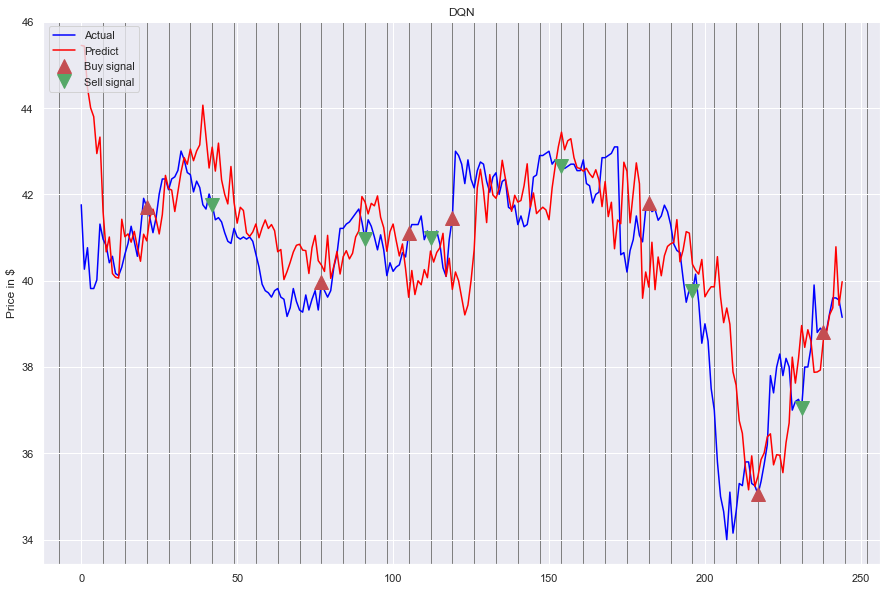

In [126]:
plt.rcParams.update({'font.size': 18})

# Initialize the `signals` DataFrame with the `signal` column
#prices_show = series.values
prices_show = df['close'].values[-245:]
prices_show = pd.Series(prices_show)
prices_show = prices_show.reset_index(drop = True)
signals_a = pd.DataFrame(index=prices_show.index)
signals_a['signal'] = 0.0
signals_a['value'] = 0.0
# Create signals
#print('action_np',action_np,'prices_show',prices_show.shape)
signals_a['signal']=action_signal
signals_a['value'] = prices_show

#print(signals_a)

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
# Initialize the plot figure
fig = plt.figure(figsize=(15,10))
# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,
ylabel='Price in $')
plt.title('DQN')
spacing = n_seq # This can be your user specified spacing.
minorLocator = MultipleLocator(spacing)
ax1.xaxis.set_minor_locator(minorLocator)
ax1.grid(which = 'minor',color='grey')
# Plot the closing price
#prices_show.plot(ax=ax1, color='b', label='Actual')
x_axis = np.arange(len(prices_show))
plt.plot(x_axis,prices_show,color='blue', label='Actual')
plt.plot(x_axis,pred_np,color='red', label='Predict')

plt.legend(loc='upper left')

# Plot the buy signals
ax1.plot(signals_a.loc[signals_a.signal == 1.0].index,signals_a.value[signals_a.signal == 1.0],'^',label='Buy signal', markersize=14, color='r')
ax1.plot(signals_a.loc[signals_a.signal == 2.0].index,signals_a.value[signals_a.signal == 2.0],'v',label='Sell signal', markersize=14, color='g') 
ax1.legend(loc='upper left');

plt.show()

In [127]:
actual_np[-7:]

array([38.900002, 38.799999, 39.25    , 39.5     , 39.400002, 39.400002,
       39.349998])

In [128]:
pred_np[-7:]

array([38.65168736, 38.80552399, 39.21439856, 39.37035268, 40.78537395,
       39.43142943, 39.97593101])